#### RETAIL ANALYSIS 

1. ##### Data Pre-processing
2. ##### RFM Analysis
3. ##### Market Segmentation
4. ##### Market Basket Analysis
4. ##### Conclusion

In [1]:
#Imports
#Data cleaning 
import pandas as pd
from ast import literal_eval
from datetime import datetime as dt
import numpy as np

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='white')

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers

from random import choice


#### Read Data

In [2]:
#READ DATA
#users= read_csv('../input/awssampleretaildemostore/users.csv')
users = pd.read_csv(r'.\Input\raw_users.csv', usecols =[0,1,2,3,4,5,6,7])
#items = read_csv('../input/awssampleretaildemostore/items.csv')
products = pd.read_csv(r'.\Input\raw_products.csv', 
                       usecols = [0,3,4,5,7,10])
df_lst = pd.read_csv(r'.\Input\interactions.csv',
                        iterator=True, chunksize=20000)

df = pd.concat(df_lst)    

#### Data Cleaning and Exploration

In [3]:

users.columns = [c.lower() for c in users.columns]

# Parse address information
add_lst = ['address1', 'country', 'city', 'state', 'zipcode']
users.addresses = users.addresses.apply(lambda x: [(literal_eval(x[1:-1])).\
                                                   get(i) for i in add_lst])
users[add_lst] = pd.DataFrame(users.addresses.tolist())
users.drop('addresses', axis=1, inplace = True)
users.head(3)

,id,username,email,first_name,last_name,age,gender,address1,country,city,state,zipcode
0,1,user1,mark.johnson@example.com,Mark,Johnson,31,M,51161 Maurice Fort,US,South Davidside,HI,96721
1,2,user2,kristen.calderon@example.com,Kristen,Calderon,58,F,871 Callahan Dale,US,New Candacebury,TX,79337
2,3,user3,joseph.maddox@example.com,Joseph,Maddox,43,M,03911 Cabrera Wall Suite 227,US,Martinmouth,AL,36246


In [4]:
# Clean Interaction data

#Convert timestamp
df.columns = [c.lower() for c in df.columns]
df['date'] = pd.to_datetime(df['timestamp'],  unit='s')
df.drop('timestamp', axis = 1, inplace = True)

#Check for duplicates
df.drop_duplicates(inplace = True)


In [5]:
products.rename(columns={'id': 'item_id', 'name': 'product_name'}, 
               inplace = True)

#Merge all datasets
df = df.merge(products, how='left').merge(
                                    users, how='left', left_on = 'user_id',
                                    right_on = 'id')
df.drop('id', axis = 1, inplace = True) 

### Missing data 
After the merge all fields have no missing data, in the *price* field this is intuitively not correct as some *event_type* should not have a price i.e *productViewed*. Thus set *order_completed* *event_type* to have price.

In [6]:
missing_value = df.isnull().sum()
#No missing values

In [7]:
#Remove price from non purchasing event_types
browse = ['ProductViewed', 'ProductAdded', 'CartViewed', 'CheckoutStarted']
#df['price'] = np.where(df['event_type'].isin(browse), "", df['price'])
df['price'] = pd.to_numeric(df['price'])

### Products Categories Analysis
&emsp;  **Orders, Revenue, By Categories** <br>
1.  Which are the largest product categories by order numbers, revenue, and number of products sold?<br>
2.  How do the categories compare in terms of interactions and also conversion rates?<br>
3. Which are the top and bottom 10 performing products in terms of revenue?<br>
4. What is the average revenue per order by product categories? <br>

In [8]:
#How many Categories 
df_categories = df[df['event_type'] == 'OrderCompleted'].groupby('category').agg(
                                       no_of_customers = ('user_id','nunique'),
                                       no_of_products = ('product_name', 'nunique'),
                                       revenue_by_category=('price', 'sum'),
                                       no_orders = ('price', 'count')
                                      ).reset_index()
df_categories['average_revenue_per_order'] = (df_categories['revenue_by_category']/
                                              df_categories['no_orders']).round(2)
df_categories

,category,no_of_customers,no_of_products,revenue_by_category,no_orders,average_revenue_per_order
0,accessories,415,112,55494.44,556,99.81
1,apparel,448,145,70265.96,607,115.76
2,beauty,143,44,6883.05,161,42.75
3,books,77,21,1907.21,79,24.14
4,electronics,204,23,80597.69,237,340.07
5,floral,255,14,30932.88,312,99.14
6,footwear,352,86,26296.53,447,58.83
7,furniture,427,124,179716.13,589,305.12
8,groceries,360,77,4349.39,461,9.43
9,homedecor,386,50,25318.09,494,51.25


In [9]:
print(f'There are {df_categories.no_of_customers.sum()} unique customers.')
print(f'There are {df_categories.no_of_products.sum()} unique products sold.')
print(f'A total of {"${:,.2f}".format(df_categories.revenue_by_category.sum())} revenue was generated.')
print(f'{df_categories.no_orders.sum()} orders were fulfilled.')


There are 4611 unique customers.
There are 897 unique products sold.
A total of $680,598.65 revenue was generated.
5819 orders were fulfilled.


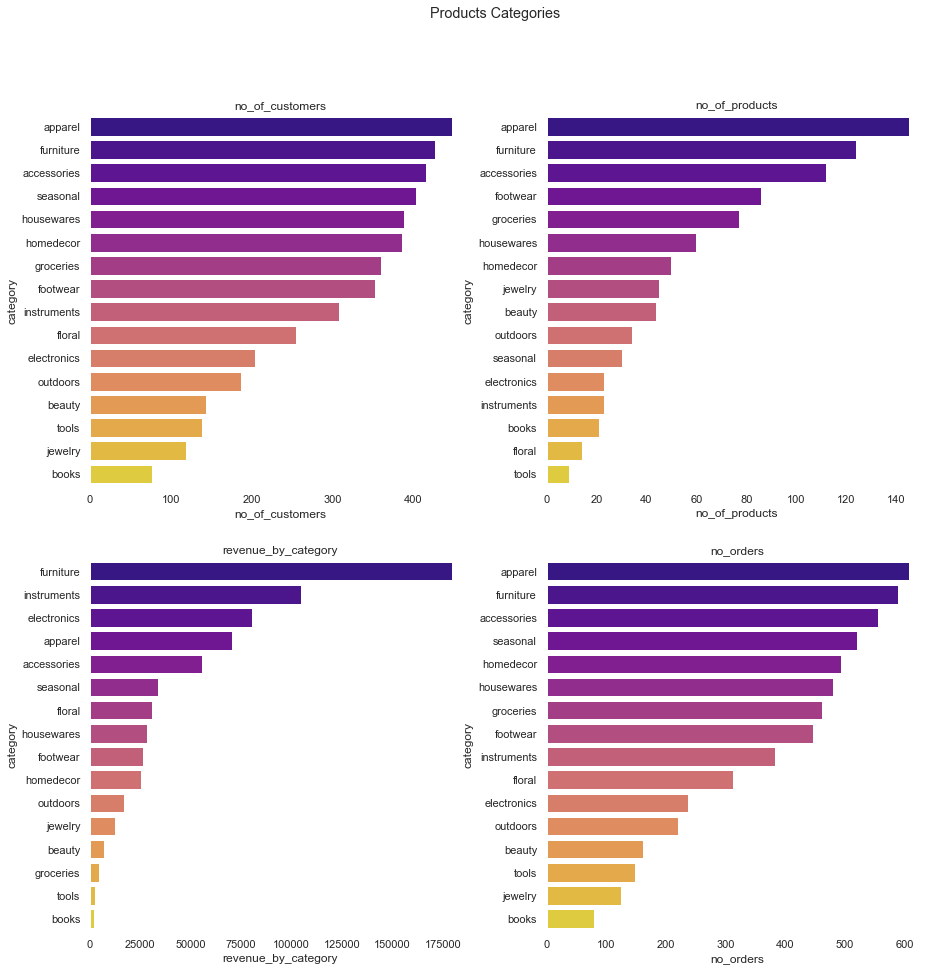

In [10]:
figure, axis = plt.subplots(2, 2,figsize=(15, 15), facecolor='w', edgecolor='k')

a = 2 #rows
b = 2 # columns
c = 1 # subplot iterator

for i in df_categories.columns[1:-1]:
    plt.subplot(a, b, c)
    plt.title(f'{i}')
    plt.xlabel(i)
    plt.suptitle('Products Categories')
    plt.ylabel('')
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.barplot(x = i, y = 'category', data = df_categories,
                order= df_categories.sort_values(
                by=[i], ascending=False).set_index('category').index,
               palette = 'plasma')
    sns.despine(bottom = True, left = True)
    c = c + 1

plt.show()

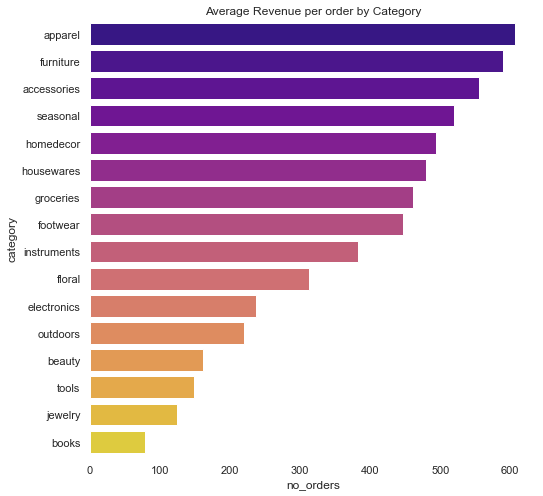

In [11]:
#High ticket categories

plt.figure(figsize=(8,8))
sns.barplot(x = i, y = 'category', data = df_categories,
               order= df_categories.sort_values(
               by=[i], ascending=False).set_index('category').index,
               palette = 'plasma')
plt.title('Average Revenue per order by Category')

sns.despine(bottom = True, left = True)

*Furniture*, *apparels*, *instruments* and *electronic* are the top categories by total revenue. Likely correlation between number of products per category and number of orders completed.
In addition *apparel*, *furniture*, *accessories* and *seasonal* categories have highest average revenue per order.

### Products
1. which product have the  highest number of orders? <br>
2. Highest and lowest revenue products

In [12]:
df_products = (df[df['event_type'] == 'OrderCompleted'].groupby('product_name').agg(
                            orders = ('user_id', 'nunique'),
                            revenue_by_product = ('price', 'sum')
                                                   ).reset_index()
                 .sort_values(by=['revenue_by_product'], ascending = False))

df_products.iloc[:10]

,product_name,orders,revenue_by_product
826,Video Camera,47,33494.50
105,Camera,36,25231.63
285,Electric Guitar,60,20651.33
7,Acoustic Drum,56,15440.41
244,Dark Slate Gray Sofa,11,10125.87
432,Keyboard,30,9831.67
375,Gray Sofa,10,9682.89
545,Pale Gray Sofa,12,8656.88
6,Acoustic Bass,25,8432.73
669,Sienna Sofa,11,8352.89


&emsp; **Interactions by category**
1. What is the overall conversion rate for the store? <br>
2. What are the conversion rates for each product categories? <br>
3. Analyze customer flow. <br>

In [13]:
df_interactions = df[['user_id', 'event_type', 'category']]
df_interactions =(df_interactions.pivot_table(index=['category'],
                                    values = 'user_id',
                                    columns='event_type', aggfunc= 'count')
                                    .reset_index().rename_axis("", axis=1)
                                     )

inter_seq = ['category','ProductViewed','ProductAdded', 'CartViewed', 'CheckoutStarted',
             'OrderCompleted']

interactions = df_interactions[inter_seq].copy()
interactions['TotalInteractions'] = (interactions[interactions.columns[1:]].apply(
                                                lambda x: sum(x), axis = 1))
interactions.sort_values(by ='TotalInteractions', ascending=False, inplace=True)
interactions

,category,ProductViewed,ProductAdded,CartViewed,CheckoutStarted,OrderCompleted,TotalInteractions
10,housewares,38559,3779,2311,967,480,46096
1,apparel,28547,4722,2861,1203,607,37940
0,accessories,26276,4351,2802,1078,556,35063
7,furniture,24535,4688,2972,1161,589,33945
9,homedecor,25421,3889,2451,953,494,33208
14,seasonal,23896,4360,2755,1062,520,32593
11,instruments,25930,3000,1893,752,383,31958
8,groceries,23842,3935,2462,932,461,31632
6,footwear,22518,3753,2359,934,447,30011
5,floral,19394,2403,1501,625,312,24235


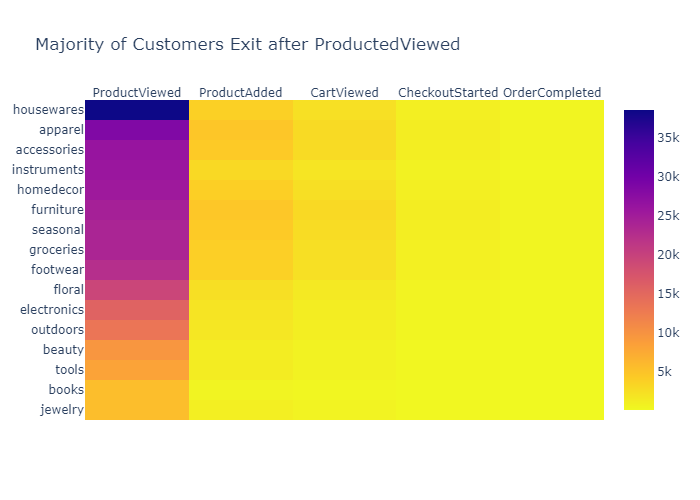

<Figure size 432x360 with 0 Axes>

In [14]:
#Conversion Absolute heatmap
df_i = (df_interactions.set_index('category')[inter_seq[1:]]
        .sort_values(by=['ProductViewed']))
plt.figure(figsize=(6,5))

fig = go.Figure(data =
                go.Heatmap(x = df_i.columns, y = df_i.index.values,
                z = df_i.values,
                colorscale = 'plasma_r'))

fig.update_xaxes(side="top")
fig.update_layout(title_text = 'Majority of Customers Exit after ProductedViewed')
fig.show(renderer= "png")

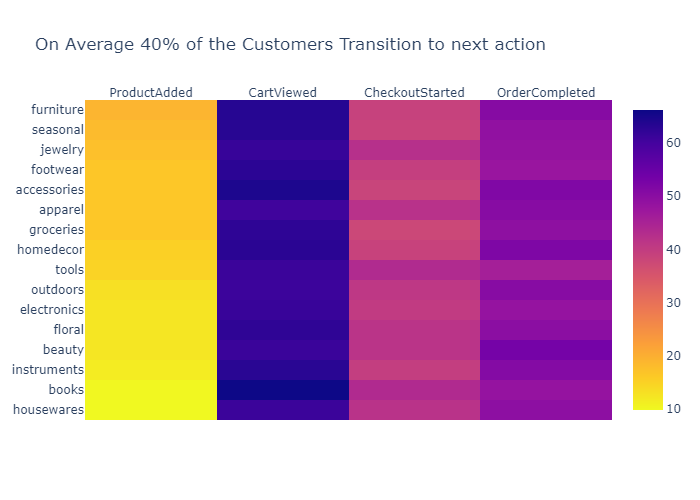

<Figure size 432x360 with 0 Axes>

In [15]:
transition_rates = interactions[interactions.columns[:-1]].copy()

def trans_rate(f, t):
    rate = (transition_rates[t]*100/transition_rates[f]).round(2)
    return rate

actions = ['ProductViewed', "ProductAdded", 'CartViewed','CheckoutStarted', 'OrderCompleted']
rate_lst = [trans_rate(actions[i],actions[i+1]) for i in range(len(actions)-1)]

trans_matrix = pd.DataFrame(zip(*rate_lst), index=transition_rates.category,
                           columns= actions[1:])

trans_matrix = trans_matrix.sort_values(by='ProductAdded')

#Conversion percent heatmap
plt.figure(figsize=(6,5))
fig = go.Figure(data =
            go.Heatmap(x = trans_matrix.columns, y = trans_matrix.index.values,
            z = trans_matrix.values,
            colorscale = 'plasma_r'))

fig.update_xaxes(side="top")
fig.update_layout(title_text = 'On Average 40% of the Customers Transition to next action ')
fig.show(renderer= "png")
#rate_lst

### Conversion Rates

In [16]:
#Calculate conversion rate
interactions['Conversion_rate'] = (interactions['OrderCompleted'] *100/
                                      interactions['TotalInteractions']).round(3)
interactions

,category,ProductViewed,ProductAdded,CartViewed,CheckoutStarted,OrderCompleted,TotalInteractions,Conversion_rate
10,housewares,38559,3779,2311,967,480,46096,1.041
1,apparel,28547,4722,2861,1203,607,37940,1.600
0,accessories,26276,4351,2802,1078,556,35063,1.586
7,furniture,24535,4688,2972,1161,589,33945,1.735
9,homedecor,25421,3889,2451,953,494,33208,1.488
14,seasonal,23896,4360,2755,1062,520,32593,1.595
11,instruments,25930,3000,1893,752,383,31958,1.198
8,groceries,23842,3935,2462,932,461,31632,1.457
6,footwear,22518,3753,2359,934,447,30011,1.489
5,floral,19394,2403,1501,625,312,24235,1.287


In [17]:
print(f'The overall conversion rate is:\
       {"{:.3f}%".format(interactions.Conversion_rate.mean())}')

The overall conversion rate is:       1.409%


All product categories have a conversion rate in range 1.0 - 1.7% with *books* and *housewares* having the highest and lowest respectively.

#### Funnel Analysis
1. Bottle-neck analysis:- where most customers churn. <br>
2. Find Average duration of checkout started - conversion. <br>
3. What is the cart-abandoment rate per category and total revenue lost due to cart abandoment?

##### Bottle-neck Analysis

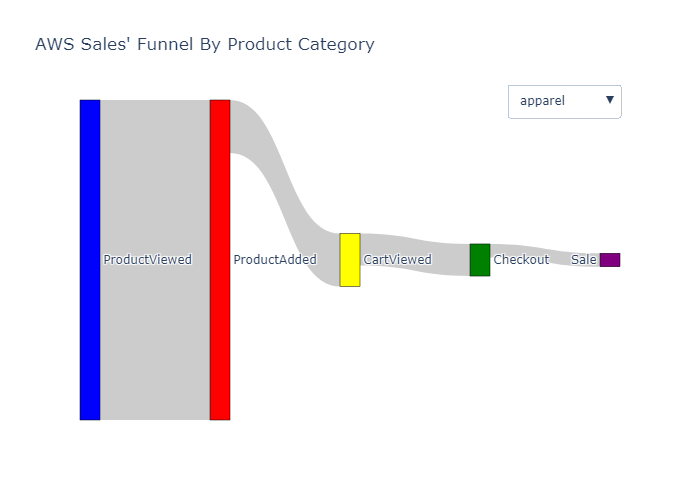

In [18]:
categories =df_i.index.values.tolist()
category_plot_names = []
fig = go.Figure()

buttons=[]

default_category = "apparel"

for cat in categories:
    x = sorted(df_i.loc[cat].values.tolist(), reverse=True)
    #print(x)
    fig.add_traces(go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['ProductViewed', "ProductAdded", 'CartViewed','Checkout', 'Sale' ],
      color = ["blue", "red", "yellow", "green", "purple", "cyan", "black"] 
    ),
    link = dict(
      source = [0, 1, 2, 3, 4],
      target = [1, 2, 3, 4],
      value = x
    ), 
    visible=(cat==default_category)
    ))
    
    category_plot_names.append(cat)
    
for cat in categories:
    buttons.append(dict(method='update',
                        label=cat,
                        args = [{'visible': [cat==r for r in category_plot_names]}])) 
    
# Add dropdown menus to the figure
fig.update_layout(showlegend=False, updatemenus=[{"buttons": buttons, "direction": "down",
                                                  "active": categories.index(default_category),
                                                  "showactive": True, "x": 1, "y": 1.05}],
                  title_text = "~ 85% of Total customers Churn at Product-Viewed")
fig.show(renderer= "png")
#fig.write_html('Sales funnel.html', auto_open=True)


##### Checkout Duration

In [120]:
#filter only customers who have purchased a product
buyers = list(set(df[df['event_type'] == 'OrderCompleted']['user_id'].values))
df_buyers = df[df['user_id'].isin(buyers)]

df_buyers  = df_buyers[(df['event_type'] == 'CheckoutStarted') | (df["event_type"] == 'OrderCompleted')]
df_buyers  = df_buyers.groupby(['user_id', 'item_id', 'event_type']).date.min().reset_index()
df_buyers = pd.pivot_table(df_buyers, columns='event_type', index=['user_id', 'item_id'] ).reset_index()
df_buyers.columns = ["".join(a).replace('date', "") for a in df_buyers.columns.to_flat_index()]
df_buyers['checkout_duration'] = (df_buyers['OrderCompleted'] - df_buyers['CheckoutStarted'])\
                                          .fillna(pd.Timedelta(seconds=10000)).dt.seconds                                           
                                          
df_buyers = df_buyers[df_buyers['checkout_duration'] !=10000]

c:\Users\DIANA\Desktop\E-commerce-RFM-Analysis\rfm\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [126]:
df_buyers['less than 4 mins'] = np.where(df_buyers['checkout_duration'] < 241, 
                                         1,0)
avg_checkout_duration = round(df_buyers['checkout_duration'].mean()/60, 2)
checkout_within_4mins = round(df_buyers['less than 4 mins'].mean(), 3)*100
print(f'The average duration from checkoutStarted to OrderCompleted is {avg_checkout_duration} minutes.')
print(f'{checkout_within_4mins} % of all purchasing customers checkout within 4 Mins.')


The average duration from checkoutStarted to OrderCompleted is 31.23 minutes.
95.5 % of all purchasing customers checkout within 4 Mins.


##### Cart Abandonment 

In [143]:
#Cart abandonment consists events_type(Added to cart and checkout started)
df_pivoted = pd.pivot_table(df, index=['user_id', 'item_id', 'category', 'price'], columns= 'event_type', 
               values= 'date', aggfunc= 'first').reset_index()
df_pivoted['Abandoned Flag'] = np.where(df_pivoted['ProductAdded'].notna() &
                                        df_pivoted['OrderCompleted'].isna(), 1,0)
df_pivoted.head(2)


event_type,user_id,item_id,category,price,CartViewed,CheckoutStarted,OrderCompleted,ProductAdded,ProductViewed,Abandoned Flag
0,1,18ea792e-2dc0-4dd0-8cdd-29266d333412,housewares,64.99,NaT,NaT,NaT,NaT,2020-07-27 14:58:00,0
1,1,3ce61cd6-8cbd-42d7-9563-37eb7378fbc5,furniture,151.99,2020-07-18 19:16:43,NaT,NaT,2020-07-18 19:16:38,2020-06-10 16:22:34,1


In [153]:
df_abandoned = df_pivoted[df_pivoted['ProductAdded'].notnull()].groupby(
            'category').agg(percent_abandoned = ('Abandoned Flag', lambda x : round(np.mean(x)*100,2)),
            Total_revenue = ('price', 'sum'))
df_abandoned

,percent_abandoned,Total_revenue
category,,
accessories,80.29,272376.16
apparel,81.45,358973.93
beauty,84.46,40484.44
books,85.01,12850.73
electronics,84.90,485341.80
floral,82.33,166341.19
footwear,82.97,160294.99
furniture,81.90,928766.86
groceries,83.37,23872.97


#### Time of Purchase

In [19]:
df['date'].dt.month.unique()
#This is 3 Months of data june/july/ August

df['month'] = df['date'].dt.month_name()

df['hod'] = [r.hour for r in df.date]
df['day_of_year'] = df['date'].dt.strftime('%j')
df['day_of_week'] = df['date'].dt.strftime('%a')
              

In [20]:
df_t = df.groupby('month').agg(no_of_customers = ('user_id','nunique'),
                           no_of_products = ('product_name', 'nunique'),
                           revenue_by_category=('price', 'sum'),
                           no_orders = ('price', 'count')
                          ).reset_index()
#Reorder by Month
sort_order= ['June', 'July', 'August'] #category order
df_t.index = pd.CategoricalIndex(df_t['month'], categories=sort_order, ordered=True)
df_t = df_t.sort_index().reset_index(drop = True)   
df_t['revenue change %'] = ((df_t['revenue_by_category'] - df_t['revenue_by_category'].shift(1))*100/
                            df_t['revenue_by_category']).round(2)
df_t                        

,month,no_of_customers,no_of_products,revenue_by_category,no_orders,revenue change %
0,June,6000,952,12919777.44,110571,NaN
1,July,6000,952,20230233.56,173306,36.14
2,August,6000,952,14806052.21,126191,-36.63


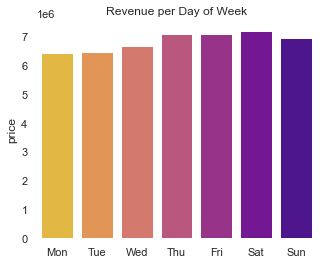

In [21]:
#What is the distribution of sales over time(day of week)?
revenue_by_day = pd.DataFrame(df.groupby('day_of_week', as_index= True)['price'].sum())
cats = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
revenue_by_day.index = pd.Categorical(revenue_by_day.index, categories= cats, ordered=True)
revenue_by_day = revenue_by_day.sort_index()

plt.figure(figsize=(5,4))
sns.barplot(y = 'price', x = revenue_by_day.index, data = revenue_by_day,  
               palette = 'plasma_r')
plt.title('Revenue per Day of Week')

sns.despine(bottom = True, left = True)

Revenue/sales per day of week are uniformly distributed.

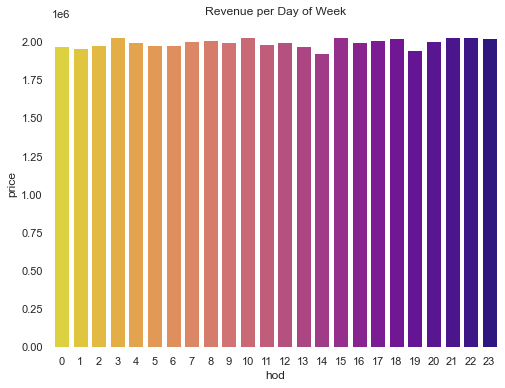

In [22]:
plt.figure(figsize=(8,6))
revenue_by_hod = pd.DataFrame(df.groupby('hod', as_index= True)['price'].sum())
sns.barplot(y = 'price', x = revenue_by_hod.index, data = revenue_by_hod,  
               palette = 'plasma_r')
plt.title('Revenue per Day of Week')

sns.despine(bottom = True, left = True)

#### Sales by Geography/Region

In [23]:
df.state.nunique()

51

In [24]:
df_geo = df[df['event_type'] == 'OrderCompleted'].groupby('state').agg(
                                    orders = ('user_id', 'nunique'),
                                    revenue_by_state = ('price', 'sum')).reset_index()

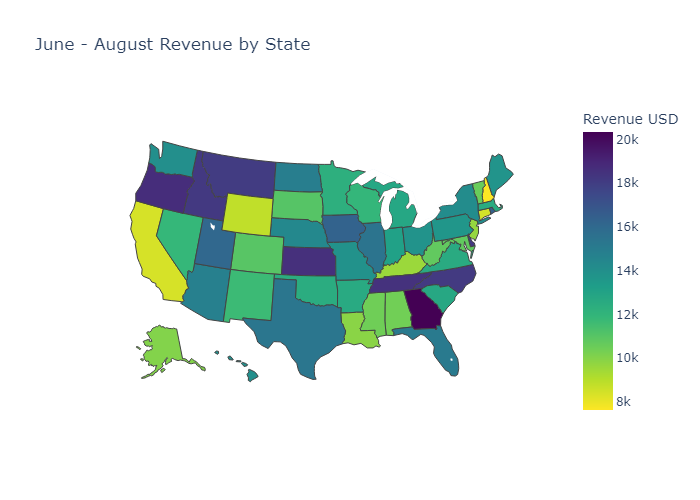

In [25]:
fig = go.Figure(data=go.Choropleth(
    locations=df_geo['state'], # Spatial coordinates
    z = df_geo['revenue_by_state'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'viridis_r',
    colorbar_title = "Revenue USD",
))

fig.update_layout(
    title_text = 'June - August Revenue by State',
    geo_scope='usa', # limite map scope to USA
    )

fig.show(renderer="png")

### Zipcodes & ZCTAs

In [26]:
print (f'We have sold products in {df.zipcode.nunique()} zipcodes')

We have sold products in 5509 zipcodes


In [27]:
#Check for missing zipcode
sum(df.zipcode.isnull()) #No missing records
#Check the length of each zipcode
df.zipcode.str.len().unique() # All zipcodes are 5 digits long

#Load zipcodes-zctas classification dataset
eco_status = pd.read_csv('zipcodes_zcta_classified.csv')
eco_status.columns = [c.lower().replace('_', '') for c in eco_status.columns]
eco_status.zipcode = eco_status.zipcode.astype('str')

#merge 
df_geo = df.merge(eco_status, how= 'left', on=['zipcode', 'zipcode'])
df_geo.head()

,item_id,user_id,event_type,discount,date,product_name,category,style,price,current_stock,...,city,state_x,zipcode,month,hod,day_of_year,day_of_week,zcta,state_y,status
0,94cc3c8d-7efd-4f7b-84d0-9996f7e90c2f,3156,ProductViewed,No,2020-06-10 15:43:08,Pots Set,housewares,kitchen,66.99,16,...,New Jonathanstad,LA,70126,June,15,162,Wed,70126.0,LA,middle
1,e2c8393e-2109-4a91-966f-f30274d0515d,332,ProductViewed,Yes,2020-06-10 15:43:32,Ultrachic Belt,accessories,belt,74.99,14,...,Lake Adrianburgh,MT,59095,June,15,162,Wed,NaN,NaN,NaN
2,494d3480-3c7d-448e-8d3b-834b06fff156,3981,ProductViewed,Yes,2020-06-10 15:43:50,Spiffy Sandals,footwear,sandals,9.99,10,...,Justinchester,KY,40011,June,15,162,Wed,40011.0,KY,lower
3,101172c2-2a10-4597-bdc2-bc8f5583ef6a,3905,ProductViewed,No,2020-06-10 15:44:11,Utensils,housewares,kitchen,50.99,10,...,Bushberg,VA,22309,June,15,162,Wed,22309.0,VA,middle
4,5b3b7662-c6b6-4b5a-b07c-4a55b417b071,4135,ProductViewed,Yes,2020-06-10 15:44:32,Roses Arrangement,floral,arrangement,126.99,11,...,Michaelton,GA,30525,June,15,162,Wed,30525.0,GA,lower


In [28]:
#Input missing status field with random selected value from status column
labels_status = df_geo['status'].dropna().values
df_geo.status= df_geo.status.apply(lambda x: choice(labels_status)
                                   if x is np.nan else x)


In [29]:
#How many sales from each status classifications
sales_by_status = df_geo[df['event_type'] == 'OrderCompleted'].groupby(
    ['status'], as_index = False).agg(
    no_of_orders = ('user_id', 'count'),
    total_revenue = ('price', 'sum')
    )
sales_by_status

,status,no_of_orders,total_revenue
0,lower,1666,189831.54
1,middle,2396,290425.37
2,upper,1757,200341.74


In [30]:
sales_by_status['% of orders'] = (sales_by_status['no_of_orders']*100 /
                                  sales_by_status['no_of_orders'].sum()).round(2)
sales_by_status['% of revenue'] = (sales_by_status['total_revenue']*100 /
                                  sales_by_status['total_revenue'].sum()).round(2)
sales_by_status

,status,no_of_orders,total_revenue,% of orders,% of revenue
0,lower,1666,189831.54,28.63,27.89
1,middle,2396,290425.37,41.18,42.67
2,upper,1757,200341.74,30.19,29.44


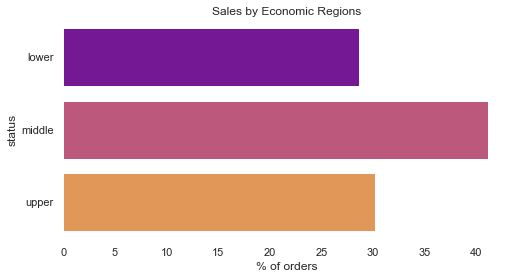

In [31]:
#Sales by economic regions
plt.figure(figsize=(8,4))
sns.barplot(x = '% of orders', y = 'status', data = sales_by_status,
               palette = 'plasma')
plt.title('Sales by Economic Regions')

sns.despine(bottom = True, left = True)

In [32]:
#How many sales from each status classifications
sales_by_gender = df_geo[df['event_type'] == 'OrderCompleted'].groupby(
    ['gender', 'category'], as_index = False).agg(
    no_of_orders = ('user_id', 'count'),
    total_revenue = ('price', 'sum'),
    
    )
sales_by_gender['revenue per order'] = (sales_by_gender['total_revenue']/sales_by_gender['no_of_orders']).round(2)

sales_by_gender_category = pd.pivot_table(sales_by_gender, columns='gender', index=['category'])
sales_by_gender_category.columns = ["_".join(a) for a in sales_by_gender_category.columns.to_flat_index()]
sales_by_gender_category

,no_of_orders_F,no_of_orders_M,revenue per order_F,revenue per order_M,total_revenue_F,total_revenue_M
category,,,,,,
accessories,316,240,97.49,102.86,30807.84,24686.60
apparel,316,291,112.06,119.78,35410.87,34855.09
beauty,106,55,45.11,38.21,4781.60,2101.45
books,44,35,25.10,22.93,1104.56,802.65
electronics,112,125,360.86,321.45,40415.94,40181.75
floral,174,138,97.40,101.34,16948.26,13984.62
footwear,212,235,39.37,76.38,8346.88,17949.65
furniture,270,319,302.77,307.11,81747.31,97968.82
groceries,209,252,8.96,9.83,1871.91,2477.48


In most product categories there is no significant difference between male and female average order value with exception  of outdoors, jewelry and footwear categories.

#### Discount
what proportion of customers purchased goods with discount offer.

In [33]:
df.discount[0] =='No'

True

In [34]:
#df.discount = df.discount.map({'Yes': 1, 'No': 0})
df_discounted = df[df['event_type'] == 'OrderCompleted'].groupby(
                        ['discount', 'category'], as_index = False).agg(
                        no_of_orders = ('user_id', 'count'))
df_discounted = (pd.crosstab(df_discounted.category, df_discounted.discount,
                        df_discounted.no_of_orders, aggfunc='first', normalize='index')\
    .round(4)*100).reset_index()
df_discounted


discount,category,No,Yes
0,accessories,59.17,40.83
1,apparel,68.86,31.14
2,beauty,60.25,39.75
3,books,56.96,43.04
4,electronics,65.40,34.60
5,floral,62.50,37.50
6,footwear,63.98,36.02
7,furniture,69.10,30.90
8,groceries,63.56,36.44
9,homedecor,66.40,33.60
